<a href="https://colab.research.google.com/github/Gedeon-m-gedus/Image_Processing/blob/master/CV_17detection_AERIAL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')#
#root_path = 'gdrive/My Drive/AMMI_project/object_detector'

Mounted at /content/gdrive


In [8]:
# unzipping the data into the dataset folder
!unzip -q /content/gdrive/My\ Drive/AMMI_project/MICHAEL/DATA.zip -d dataset/

In [3]:
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html >/dev/null
!pip install cython pyyaml==5.1 >/dev/null
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI' >/dev/null
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

# install detectron2:
!pip install detectron2==0.1.2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu101/index.html >/dev/null

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import os
import random
import time
import matplotlib.pyplot as plt
import numpy as np
import cv2
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
from detectron2.utils.visualizer import ColorMode
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader
#from detectron2.data.datasets import register_pascal_voc

  Running command git clone -q https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-vh3ny326
1.5.0+cu101 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [4]:
import numpy as np
import os
import xml.etree.ElementTree as ET
from typing import List, Tuple, Union
from fvcore.common.file_io import PathManager

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.structures import BoxMode

In [5]:
# fmt: off
CLASS_NAMES = ('plane', 
                'baseball-diamond', 
                'bridge', 
                'ground-track-field',
                'small-vehicle', 
                'large-vehicle', 
                'ship', 
                'tennis-court',
                'basketball-court',
                'storage-tank',  
                'soccer-ball-field', 
                'roundabout', 
                'harbor', 
                'swimming-pool', 
                'helicopter')
# fmt: on

def load_voc_instances(dirname: str, split: str, class_names: Union[List[str], Tuple[str, ...]]):
    """
    Load Pascal VOC detection annotations to Detectron2 format.
    Args:
        dirname: Contain "Annotations", "ImageSets", "JPEGImages"
        split (str): one of "train", "test", "val", "trainval"
        class_names: list or tuple of class names
    """
    with PathManager.open(os.path.join(dirname, split + ".txt")) as f:
        fileids = np.loadtxt(f, dtype=np.str)

    # Needs to read many small annotation files. Makes sense at local
    annotation_dirname = PathManager.get_local_path(os.path.join(dirname, "annotations/"))
    dicts = []
    for fileid in fileids:
        anno_file = os.path.join(annotation_dirname, fileid + ".xml")
        jpeg_file = os.path.join(dirname, "IMAGES/", fileid + ".png")

        with PathManager.open(anno_file) as f:
            tree = ET.parse(f)

        r = {
            "file_name": jpeg_file,
            "image_id": fileid,
            "height": int(tree.findall("./size/height")[0].text),
            "width": int(tree.findall("./size/width")[0].text),
        }
        instances = []

        for obj in tree.findall("object"):
            cls = obj.find("name").text
            # We include "difficult" samples in training.
            # Based on limited experiments, they don't hurt accuracy.
            # difficult = int(obj.find("difficult").text)
            # if difficult == 1:
            # continue
            bbox = obj.find("bndbox")
            bbox = [float(bbox.find(x).text) for x in ["xmin", "ymin", "xmax", "ymax"]]
            # Original annotations are integers in the range [1, W or H]
            # Assuming they mean 1-based pixel indices (inclusive),
            # a box with annotation (xmin=1, xmax=W) covers the whole image.
            # In coordinate space this is represented by (xmin=0, xmax=W)
            bbox[0] -= 1.0
            bbox[1] -= 1.0
            instances.append(
                {"category_id": class_names.index(cls), "bbox": bbox, "bbox_mode": BoxMode.XYXY_ABS}
            )
        r["annotations"] = instances
        dicts.append(r)
    return dicts


def register_pascal_voc(name, dirname, split, year, class_names=CLASS_NAMES):
    meta_data = DatasetCatalog.register(name, lambda: load_voc_instances(dirname, split, class_names))
    catalog = MetadataCatalog.get(name).set(
        thing_classes=list(class_names), dirname=dirname, year=year, split=split
    )
    #return meta_data, catalog

In [6]:
name = 'mydata'
dirname = './dataset/DATA/'

In [9]:
#train_meta_data, train_catalog = 
register_pascal_voc('train_data', dirname, split = 'train', year='2020', class_names=CLASS_NAMES)
train_dataset_dicts = DatasetCatalog.get('train_data')
train_metadata=MetadataCatalog.get('train_data')
register_pascal_voc('valid_data', dirname, split = 'valid', year='2020', class_names=CLASS_NAMES)
valid_dataset_dicts = DatasetCatalog.get('valid_data')
valid_metadata=MetadataCatalog.get('valid_data')

In [10]:
valid_dataset_dicts[0]

{'annotations': [{'bbox': [999.0, 70.0, 1046.0, 103.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 4},
  {'bbox': [722.0, 258.0, 761.0, 341.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [974.0, 420.0, 1016.0, 498.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [947.0, 422.0, 990.0, 505.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [799.0, 525.0, 839.0, 619.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [769.0, 526.0, 810.0, 622.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [537.0, 558.0, 580.0, 646.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [502.0, 559.0, 549.0, 636.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [212.0, 565.0, 394.0, 632.0],
   'bbox_mode': <BoxMode.XYXY_ABS: 0>,
   'category_id': 5},
  {'bbox': [751.0, 248.0, 813.0, 398.0],
   'bbox_mode': <BoxMode.

visualizing  ./dataset/DATA/IMAGES/P0885.png


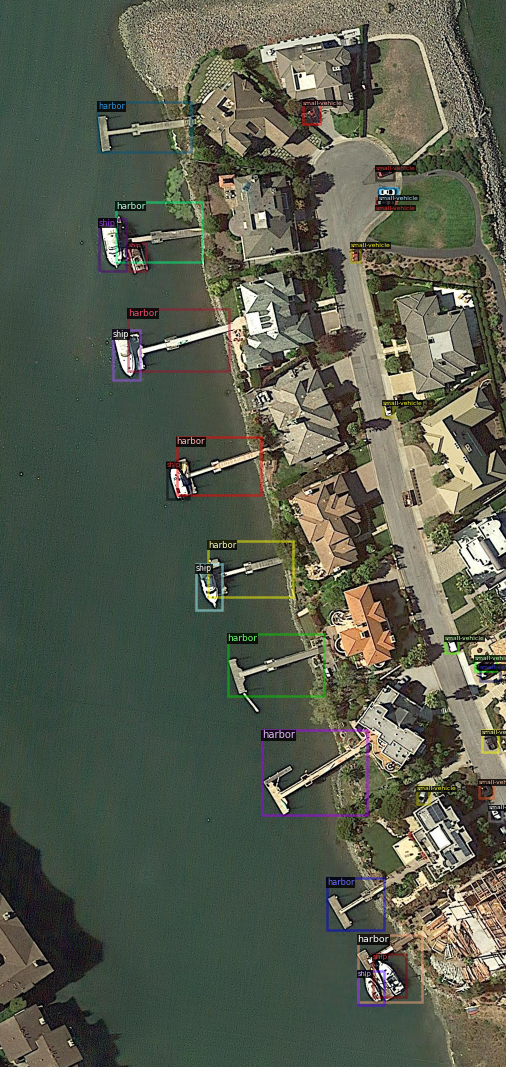

visualizing  ./dataset/DATA/IMAGES/P2116.png


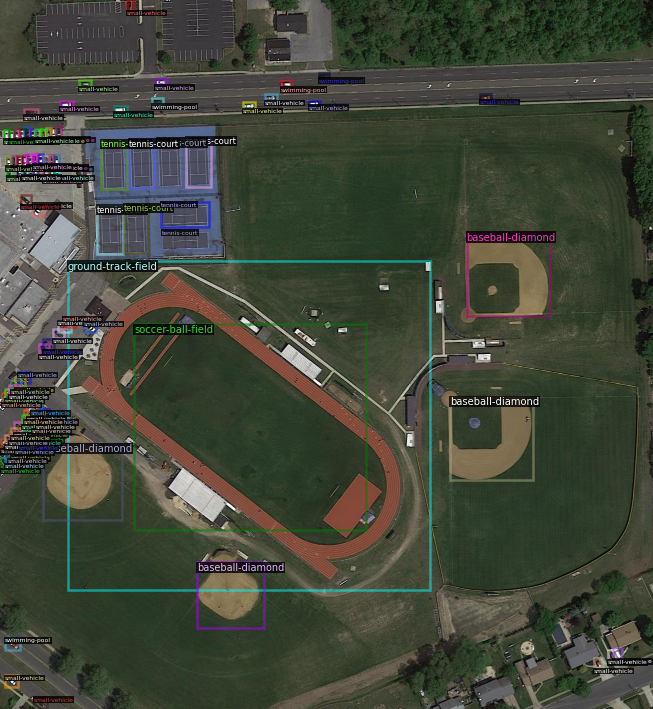

visualizing  ./dataset/DATA/IMAGES/P0884.png


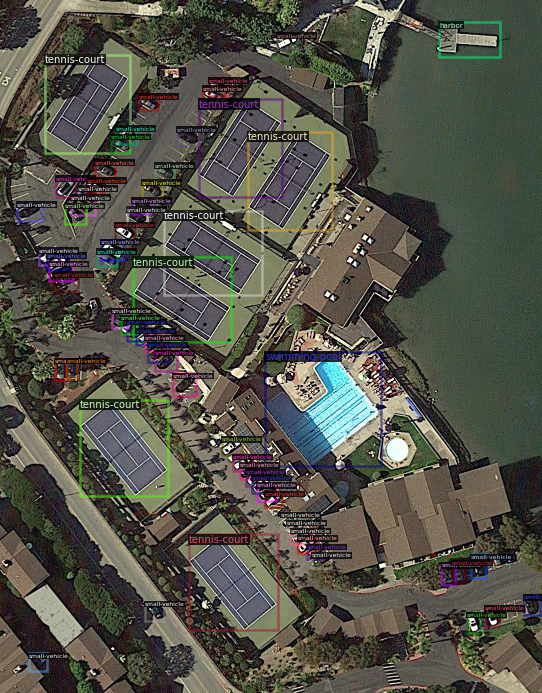

visualizing  ./dataset/DATA/IMAGES/P0861.png


In [ ]:
images_index = [0,7,78,156,345,90,55,3,9,47,1,77]
for index in images_index:
    img = cv2.imread(train_dataset_dicts[index]["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=train_metadata, scale=0.5)
    vis = visualizer.draw_dataset_dict(train_dataset_dicts[index])
    print('visualizing ',train_dataset_dicts[index]["file_name"])
    cv2_imshow(vis.get_image()[:, :, ::-1])

In [12]:
def rcnn_R_50(init_weights_flag = True, path = '/COCO_init_model'):

      cfg = get_cfg()
      cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml"))
      cfg.DATASETS.TRAIN = ("train_data",)
      cfg.DATASETS.TEST = ()
      cfg.DATALOADER.NUM_WORKERS = 2
      cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/faster_rcnn_R_50_FPN_3x.yaml")
      cfg.SOLVER.IMS_PER_BATCH = 8 # images per batch
      cfg.SOLVER.BASE_LR = 0.02  # Learning rate
      cfg.SOLVER.MAX_ITER = 300    # number of iterations 
      cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128 #regions per batch
      cfg.MODEL.ROI_HEADS.NUM_CLASSES = 15  #three classes
      cfg.with_coco_init = init_weights_flag # Flag to initialize weight to COCO or IMAGENET

      #create a path where I will store my model, this path defers for each model
      os.makedirs(path, exist_ok=True)
      cfg.OUTPUT_DIR = path
      trainer = DefaultTrainer(cfg) 
      trainer.resume_or_load(resume=False)
      trainer.train()

      ## After training lets return the predictor
      cfg.MODEL.WEIGHTS = os.path.join(path, "model_final.pth")
      cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.7   # set the testing threshold for this model
      cfg.DATASETS.TEST = ("valid_data", )

      return DefaultPredictor(cfg),cfg,trainer

In [13]:
coco_init_predictor, coco_init_cfg, coco_init_trainer = rcnn_R_50()

[10/29 12:57:08 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_280758.pkl: 167MB [00:05, 32.4MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (16, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (16,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (60, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (60,) in the model! You might want to double check if this is expected.


[10/29 12:57:27 d2.engine.train_loop]: Starting training from iteration 0
[10/29 12:57:33 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f84af276840> to CPU due to CUDA OOM
[10/29 12:57:34 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f84af276840> to CPU due to CUDA OOM
[10/29 12:57:38 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f84af276840> to CPU due to CUDA OOM
[10/29 12:57:39 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f84af276840> to CPU due to CUDA OOM
[10/29 12:57:40 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f84af276840> to CPU due to CUDA OOM
[10/29 12:57:42 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f84af276840> to CPU due to CUDA OOM
[10/29 12:57:51 d2.utils.memory]: Attempting to copy inputs of <function pairwise_iou at 0x7f84af276840> to CPU due to CUDA OOM
ERROR [10/29 12:57:53 d2.engin

RuntimeError: ignored

In [ ]:

from google.colab.patches import cv2_imshow
for d in valid_dataset_dicts:
  img = cv2.imread(d["file_name"])
  prediction = coco_init_predictor(img)
  visualizer = Visualizer(img[:, :, ::-1],
                                metadata=valid_metadata,
                                scale=0.5)
  vis = visualizer.draw_instance_predictions(prediction["instances"].to("cpu"))
  cv2_imshow( vis.get_image()[:, :, ::-1])

In [ ]:
evaluator = COCOEvaluator("valid_data", coco_init_cfg, False, output_dir="./dataset")
val_loader = build_detection_test_loader(coco_init_cfg, "valid_data")
inference_on_dataset(coco_init_trainer.model, val_loader, evaluator)